In [20]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as signal
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import datetime
import pickle
import importlib
import json
import time
import glob

from eve_part.data.constant import wavelength_list_eve
from eve_part.gaussian_fit_eve import gaussian_fit_eve



import sunpy.map
import sunpy.visualization.colormaps as cm
import sunpy.sun.constants
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from aiapy.calibrate import register, update_pointing,normalize_exposure

from astropy.constants import G, M_sun, R_sun, au
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy.units import imperial
from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const

import scipy
from scipy import ndimage

import math
from math import pi
import glob
import time
import datetime
import os
import importlib
import warnings

from PIL import Image
from fpdf import FPDF

import aia_part
from aia_part.pixel_to_world.std_pixel_to_world import std_pixel_to_world
from aia_part.pixel_to_world.my_pixel_to_world import my_pixel_to_world
from aia_part.calculate_DN import calculate_DN
from aia_part.gaussian_fit_aia import gaussian_fit_aia
from aia_part.data.constant import wavelength_list_aia_absolute

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


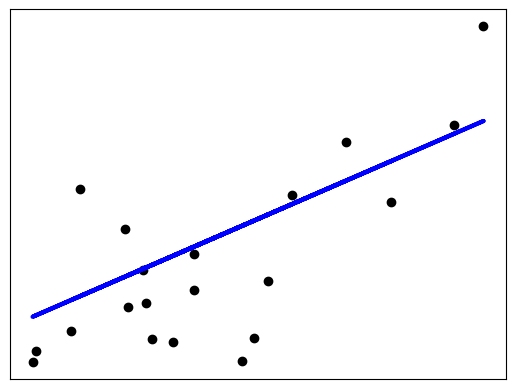

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()


# 3D irradiance

## EVE

In [2]:
def get_eve_data(start_date,end_date):
    daily_fit_df=pd.read_csv ('eve_part/data/daily_data.csv')
    daily_fit_df=daily_fit_df.set_index('time')
    daily_fit_df.index = pd.to_datetime(daily_fit_df.index)
    
    selected_df = daily_fit_df.loc[start_date:end_date]
    irradiance=[]
    selected_time_list=selected_df.index
    for date in selected_time_list:
        func=models.Gaussian1D(amplitude=daily_fit_df.loc[date,'median_of_amplitude'],
                  mean=daily_fit_df.loc[date,'median_of_mean'], 
                  stddev=daily_fit_df.loc[date,'median_of_stddev'])
        irradiance.append(func(wavelength_list_eve))
    return selected_time_list,irradiance

def plotly_3d_eve(date_list,irradiance_list):
        # Generate x and y coordinates for the surface plot
    x = np.arange(np.shape(irradiance_list)[1])
    y = np.arange(np.shape(irradiance_list)[0])
    X, Y = np.meshgrid(x, y)

    # Create the surface plot
    fig = go.Figure(data=[go.Surface(x=X,y=Y,z=irradiance_list )])

    # Customize the layout
    fig.update_layout(
        title='3D Surface Plot',
        # width=550, 
        height=700,
        scene=dict(
            xaxis=dict(
                title='wavelength (nm)',
                ticktext=wavelength_list_aia_absolute[::2],  # Set the desired tick labels
                tickvals=x[::2],  # Use the x coordinates as tick values
            ),
            yaxis=dict(title='Time (10s)',
                       ticktext=date_list[::len(date_list)//5],
                      tickvals=y[::len(y)//5]),
            zaxis=dict(title='Irradiance')
        ),
        # margin=dict(l=0,r=20)
    )
    fig.show()
    
def plot_3d_eve(start_date,end_date):
    '''
    3d surface
    time 
    '''
    date_list,irradiance_list=get_eve_data(start_date,end_date)
    plotly_3d_eve(date_list,irradiance_list)

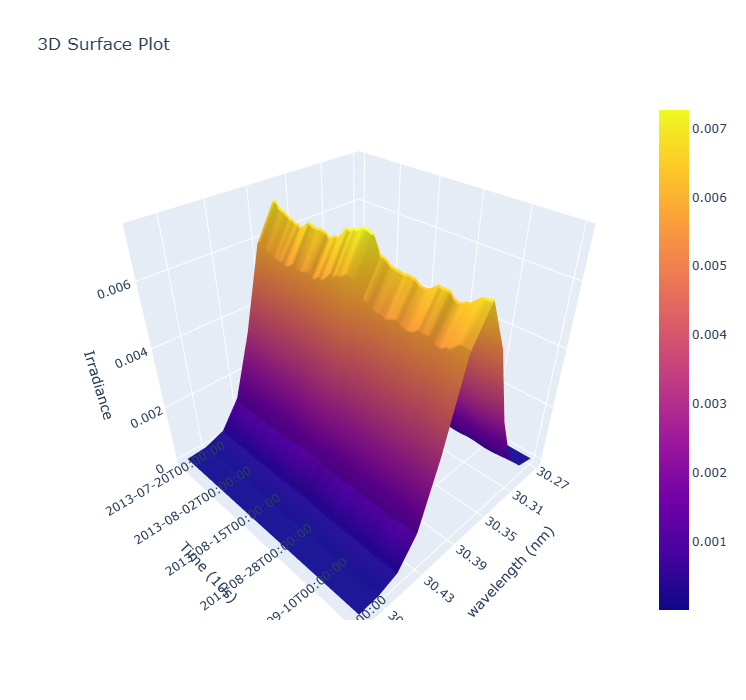

In [3]:
start_date = datetime.datetime(2013, 7, 20)
end_date = datetime.datetime(2013, 9, 23)
# original_df.index
plot_3d_eve(start_date,end_date)

## AIA

In [4]:
def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

def calculate(selected_files,a,d,e):
    irradiance_list=[]
    date_list=[]
    aia_adjusted_maps=sunpy.map.Map(selected_files)
    for m in aia_adjusted_maps:
        date,irradiance=calculate_DN(m,a=a,d=d,e=e)
        
        irradiance_list.append(irradiance)
        date_list.append(date)
    irradiance_list=np.array(irradiance_list)
    return date_list,irradiance_list

def plotly_3d_aia(date_list,irradiance_list):
        # Generate x and y coordinates for the surface plot
    x = np.arange(np.shape(irradiance_list)[1])
    y = np.arange(np.shape(irradiance_list)[0])
    X, Y = np.meshgrid(x, y)

    # Create the surface plot
    fig = go.Figure(data=[go.Surface(x=X,y=Y,z=irradiance_list )])

    # Customize the layout
    fig.update_layout(
        title='3D Surface Plot',
        # width=550, 
        height=700,
        scene=dict(
            xaxis=dict(
                title='wavelength (nm)',
                ticktext=wavelength_list_aia_absolute[::2],  # Set the desired tick labels
                tickvals=x[::2],  # Use the x coordinates as tick values
            ),
            yaxis=dict(title='Time (10s)',
                       ticktext=date_list[::len(date_list)//5],
                      tickvals=y[::len(y)//5]),
            zaxis=dict(title='Irradiance')
        ),
        # margin=dict(l=0,r=20)
    )
    fig.show()
    
def plot_3d_aia(start_date,end_date,a=0,d=0,e=0):
    selected_files=select_files(start_date,end_date)
    date_list,irradiance_list=calculate(selected_files,a=a,d=d,e=e)
    plotly_3d_aia(date_list,irradiance_list)

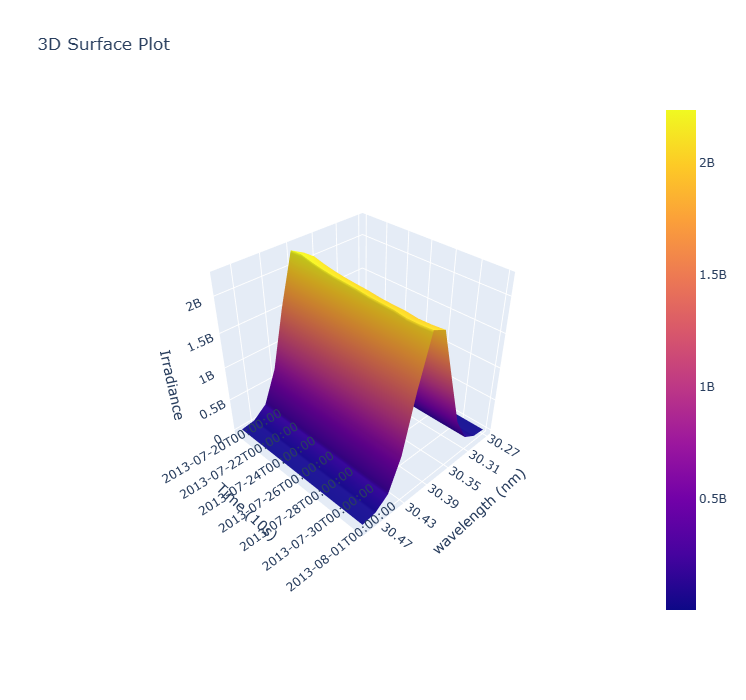

In [5]:
start_date = datetime.datetime(2013, 7, 20)
end_date = datetime.datetime(2013, 8, 1)
plot_3d_aia(start_date,end_date,a=800,d=0.9,e=0)

## combine

In [14]:
def get_eve_data(start_date,end_date):
    daily_fit_df=pd.read_csv ('eve_part/data/daily_data.csv')
    daily_fit_df=daily_fit_df.set_index('time')
    daily_fit_df.index = pd.to_datetime(daily_fit_df.index)
    
    selected_df = daily_fit_df.loc[start_date:end_date]
    irradiance=[]
    selected_time_list=selected_df.index
    for date in selected_time_list:
        func=models.Gaussian1D(amplitude=daily_fit_df.loc[date,'median_of_amplitude'],
                  mean=daily_fit_df.loc[date,'median_of_mean'], 
                  stddev=daily_fit_df.loc[date,'median_of_stddev'])
        irradiance.append(func(wavelength_list_eve))
    return selected_time_list,irradiance

def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

def calculate(selected_files,a,d,e):
    irradiance_list=[]
    date_list=[]
    aia_adjusted_maps=sunpy.map.Map(selected_files)
    for m in aia_adjusted_maps:
        date,irradiance=calculate_DN(m,a=a,d=d,e=e)
        
        irradiance_list.append(irradiance)
        date_list.append(date)
    irradiance_list=np.array(irradiance_list)
    return date_list,irradiance_list






def plotly_3d_combine(date_list,aia_irradiance_list,eve_irradiance_list):
        # Generate x and y coordinates for the surface plot
    x = np.arange(np.shape(aia_irradiance_list)[1])
    y = np.arange(np.shape(aia_irradiance_list)[0])
    X, Y = np.meshgrid(x, y)

    
    surface_aia=go.Surface(x=X,y=Y,z=aia_irradiance_list/np.average(aia_irradiance_list) )
    surface_eve=go.Surface(x=X,y=Y,z=eve_irradiance_list/np.average(eve_irradiance_list) )
    
    # Create the first surface trace with a specific color
    surface_aia = go.Surface(x=X, y=Y, z=aia_irradiance_list/np.average(aia_irradiance_list)
                             , name='AIA Irradiance', 
                             colorscale='Blues'
                            )

    # Create the second surface trace with a different cmap
    surface_eve = go.Surface(x=X, y=Y, z=eve_irradiance_list/np.average(eve_irradiance_list)
                             , name='EVE Irradiance', 
                             colorscale='Reds',
                             # colorbar=dict(xanchor='right', colorbar_x=-0.5)
                            )

    # Create the surface plot
    fig = go.Figure(data=[surface_aia,surface_eve])

    # Customize the layout
    fig.update_layout(
        title='EVE obs and AIA simu',
        # width=550, 
        height=700,
        scene=dict(
            xaxis=dict(
                title='wavelength (nm)',
                ticktext=wavelength_list_eve[::2],  # Set the desired tick labels
                tickvals=x[::2],  # Use the x coordinates as tick values
            ),
            yaxis=dict(title='Time ',
                       ticktext=date_list[::len(date_list)//3],
                      tickvals=y[::len(y)//3]),
            zaxis=dict(title='Irradiance')
        ),
        # margin=dict(l=0,r=20)
    )
    fig.show()
    fig.write_html('combine_3d.html')

In [15]:
def plot_3d_combine(start_date,end_date,a,d,e):
    aia_selected_files=select_files(start_date,end_date)
    aia_date_list,aia_irradiance_list=calculate(aia_selected_files,a,d,e)
    
    eve_date_list,eve_irradiance_list=get_eve_data(start_date,end_date)
    plotly_3d_combine(eve_date_list,aia_irradiance_list,eve_irradiance_list)
    

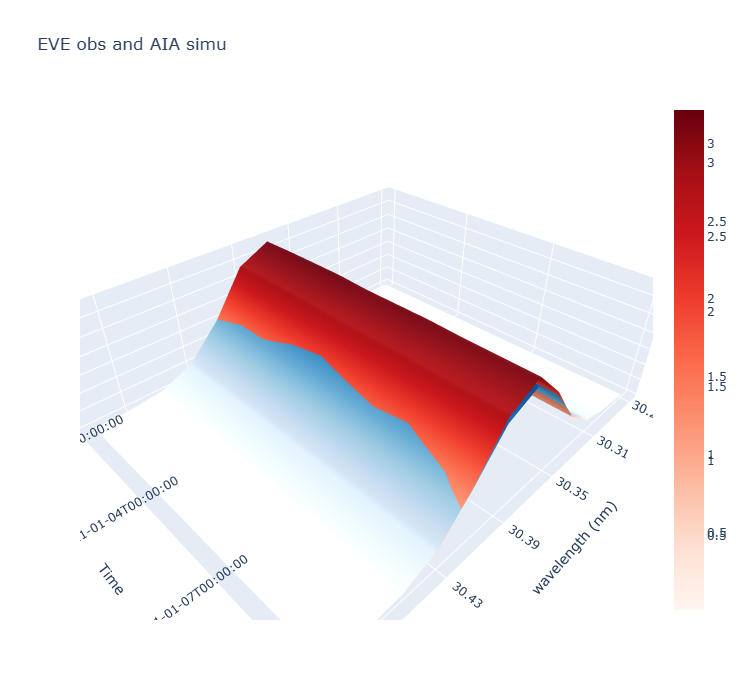

In [16]:
start_date = datetime.datetime(2011, 1, 1)
end_date = datetime.datetime(2011, 1, 10)
plot_3d_combine(start_date,end_date,a=900,d=0.9,e=-0.01)

In [ ]:
daily_fit_df=pd.read_csv ('eve_part/data/daily_data.csv')
daily_fit_df=daily_fit_df.set_index('time')
daily_fit_df.index = pd.to_datetime(daily_fit_df.index)

selected_df = daily_fit_df.loc[start_date:end_date]

In [10]:
selected_df

median_of_mean  median_of_stddev  median_of_amplitude   
time                                                                
2011-01-01       30.374072          0.028570             0.006388  \
2011-01-02       30.373920          0.028626             0.006433   
2011-01-03       30.373777          0.028658             0.006447   
2011-01-04       30.373643          0.028716             0.006454   
2011-01-05       30.373532          0.028738             0.006373   
2011-01-06       30.373523          0.028727             0.006375   
2011-01-07       30.373558          0.028742             0.006377   
2011-01-08       30.373655          0.028724             0.006318   
2011-01-09       30.373827          0.028668             0.006304   
2011-01-10       30.373989          0.028603             0.006282   

            stddev_of_mean  stddev_of_stddev  stddev_of_amplitude   
time                                                                
2011-01-01        0.000207          0.000079             0.000047  \
2011-01-02        0.000225          0.000065             0.000033   
2011-01-03        0.000189          0.000090             0.000039   
2011-01-04        0.000189          0.000059             0.000037   
2011-01-05        0.000207          0.000060             0.000036   
2011-01-06        0.000189          0.000061             0.000032   
2011-01-07        0.000189          0.000062             0.000030   
2011-01-08        0.000181          0.000064             0.000046   
2011-01-09        0.000242          0.000077             0.000045   
2011-01-10        0.000197          0.000064             0.000037   

            available_data  
time                        
2011-01-01            8584  
2011-01-02            8515  
2011-01-03            8584  
2011-01-04            8583  
2011-01-05            8583  
2011-01-06            8583  
2011-01-07            8583  
2011-01-08            8583  
2011-01-09            8515  
2011-01-10            8583

In [11]:
from astropy.stats import gaussian_fwhm_to_sigma,gaussian_sigma_to_fwhm

In [12]:
0.03*gaussian_sigma_to_fwhm

0.07064460135092848

# 2D plot

## EVE

In [24]:
def select_df(start_date,end_date):
    daily_fit_df=pd.read_csv ('eve_part/data/daily_data.csv')
    daily_fit_df=daily_fit_df.set_index('time')
    daily_fit_df.index = pd.to_datetime(daily_fit_df.index)

    selected_df = daily_fit_df.loc[start_date:end_date]
    return selected_df

In [77]:
def plotly_2d_eve(selected_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=.011)

    valid_day=np.where(selected_df['available_data']>=np.nanmean(selected_df['available_data'])*0.2,1,np.nan)
    x = selected_df.index
    y_median = selected_df['median_of_mean']*valid_day
    y_stddev = selected_df['stddev_of_mean']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    # Plot the mean line
    fig.add_trace(go.Scatter(x=x, y=y_median,
                                  showlegend=False, 
                            line=dict(color='rgb(0,128,255)', )) ,
                  row=1, col=1,)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  showlegend=False, 
                                  name='3 Std. Dev.'),
                 row=1, col=1)

    fig.update_yaxes(title_text="Mean (nm)",range=[30.3705, 30.3755],row=1, col=1)
    # Show the plot



    # Create a figure for stddev
    x = selected_df.index
    y_median = selected_df['median_of_stddev']*valid_day
    y_stddev = selected_df['stddev_of_stddev']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    fig.add_trace(go.Scatter(x=x, y=y_median,
                                # showlegend=False,
                             line=dict(color='rgb(0,128,255)'),),
                          row=2, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  # showlegend=False,
                                  name='3 Std. Dev.'),
                        row=2, col=1)

    fig.update_yaxes(title_text="Stddev (nm)",range=[0.028, 0.032],row=2, col=1)





    # # Create a figure for amplitude
    x = selected_df.index
    y_median = selected_df['median_of_amplitude']*valid_day
    y_stddev = selected_df['stddev_of_amplitude']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])


    fig.add_trace(go.Scatter(x=selected_df.index, y=y_median,
                                             # showlegend=False,
                            line=dict(color='rgb(0,128,255)'),),
                             row=3, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  # showlegend=False, 
                                  name='3 Std. Dev.'),
                           row=3, col=1)

    fig.update_yaxes(title_text='amplitude (nm)',range=[0.0059, 0.0082],row=3, col=1)
    fig.update_xaxes(title_text="Time",row=3, col=1)


    fig.update_layout(
        width=800,height=1500,
                          title_text="EVE: obs: Daily Median, Standard Deviation, Amplitude and Irradiance",
                         # legend=dict(x=1, y=0.9)
    ) 

    
    
    fig.write_html('eve_years_2d.html')
    fig.show()

In [78]:
def plot_2d_eve(start_date,end_date):
    selected_df=select_df(start_date,end_date)
    plotly_2d_eve(selected_df)

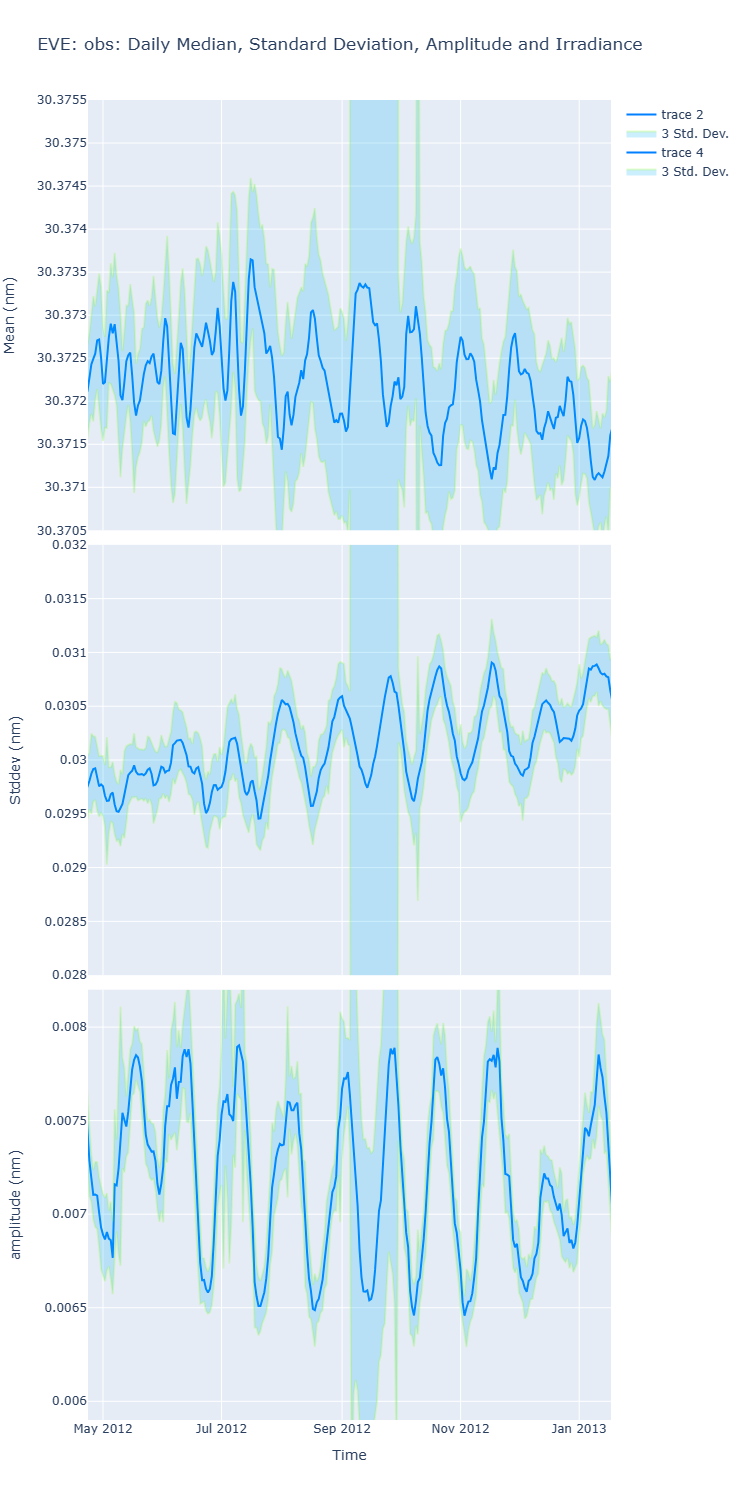

In [79]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2014, 1, 11)
plot_2d_eve(start_date,end_date)

### EVE1

In [74]:
# start_date = datetime.datetime(2010, 6, 1)
# end_date = datetime.datetime(2014, 6, 1)
start_date = datetime.datetime(2012, 6, 1)
end_date = datetime.datetime(2013, 1, 1)
selected_df=select_df(start_date,end_date)

In [75]:
selected_df

median_of_mean  median_of_stddev  median_of_amplitude   
time                                                                
2012-06-01       30.372699          0.029928             0.007254  \
2012-06-02       30.372965          0.029884             0.007471   
2012-06-03       30.372869          0.029899             0.007577   
2012-06-04       30.372459          0.029904             0.007577   
2012-06-05       30.372006          0.029975             0.007691   
...                    ...               ...                  ...   
2012-12-28       30.372227          0.030179             0.006863   
2012-12-29       30.372070          0.030222             0.006817   
2012-12-30       30.371758          0.030292             0.006849   
2012-12-31       30.371517          0.030416             0.006941   
2013-01-01       30.371571          0.030460             0.007069   

            stddev_of_mean  stddev_of_stddev  stddev_of_amplitude   
time                                                                
2012-06-01        0.000180          0.000080             0.000099  \
2012-06-02        0.000227          0.000080             0.000058   
2012-06-03        0.000351          0.000076             0.000100   
2012-06-04        0.000354          0.000098             0.000050   
2012-06-05        0.000329          0.000097             0.000098   
...                    ...               ...                  ...   
2012-12-28        0.000231          0.000106             0.000040   
2012-12-29        0.000227          0.000114             0.000043   
2012-12-30        0.000280          0.000116             0.000044   
2012-12-31        0.000243          0.000104             0.000067   
2013-01-01        0.000231          0.000144             0.000060   

            available_data  
time                        
2012-06-01            8581  
2012-06-02            8581  
2012-06-03            8513  
2012-06-04            8582  
2012-06-05            8580  
...                    ...  
2012-12-28            7863  
2012-12-29            8583  
2012-12-30            8154  
2012-12-31            8581  
2013-01-01            8582  

[215 rows x 7 columns]

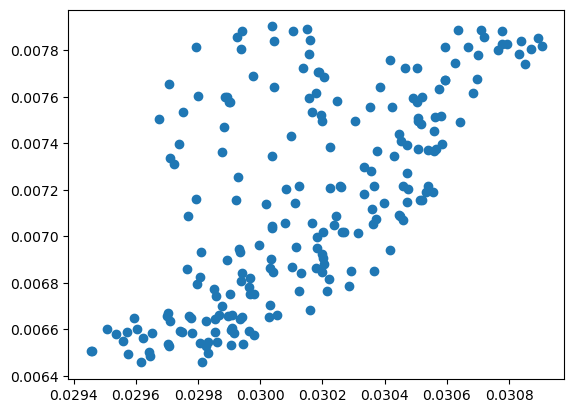

In [76]:
fig,ax=plt.subplots()
ax.scatter(selected_df['median_of_stddev'],selected_df['median_of_amplitude'])

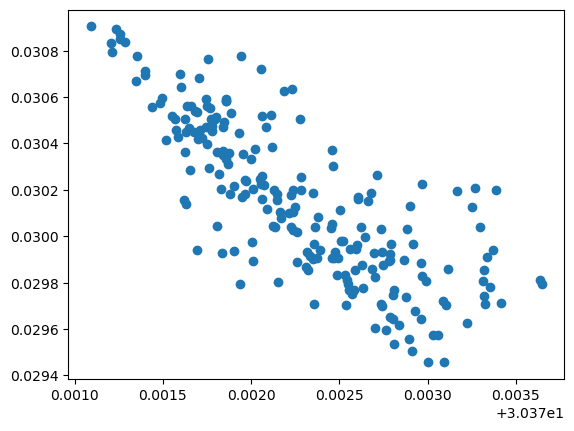

In [77]:
fig,ax=plt.subplots()
ax.scatter(selected_df['median_of_mean'],selected_df['median_of_stddev'])

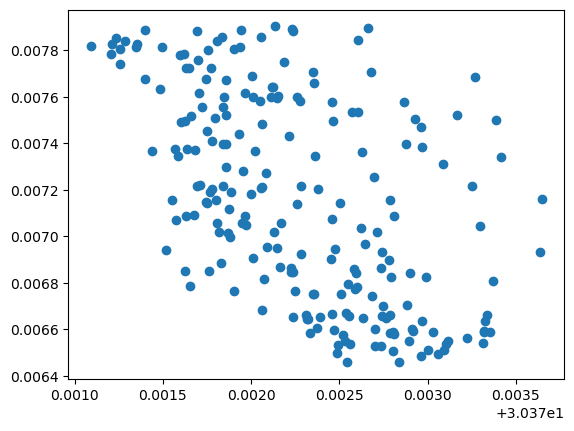

In [78]:
fig,ax=plt.subplots()
ax.scatter(selected_df['median_of_mean'],selected_df['median_of_amplitude'])

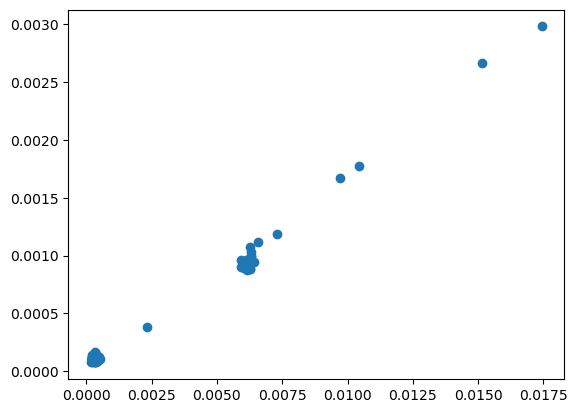

In [79]:
fig,ax=plt.subplots()
ax.scatter(selected_df['stddev_of_mean'],selected_df['stddev_of_stddev'])

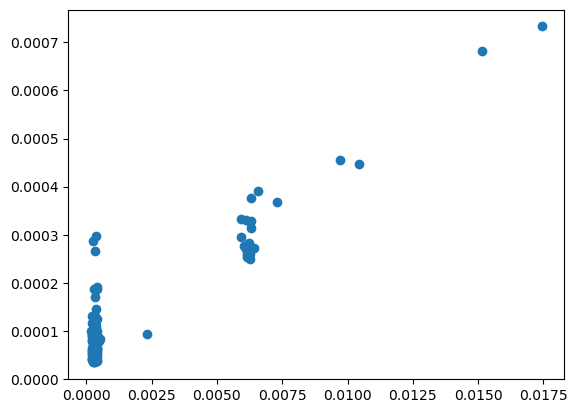

In [80]:
fig,ax=plt.subplots()
ax.scatter(selected_df['stddev_of_mean'],selected_df['stddev_of_amplitude'])

In [81]:
x = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
x

array([[1],
       [2],
       [3],
       [4],
       [5]])

#### test

In [82]:
def regression(str1,str2):
    regr = linear_model.LinearRegression()
    x=selected_df[str1].values.reshape(-1, 1)
    y=selected_df[str2].values
    # Train the model using the training sets
    regr.fit(x,y)

    # Make predictions using the testing set
    y_pre = regr.predict(x)

    print(str1,str2)
    # The coefficients
    print("\t Coefficients: ", regr.coef_)
    # The mean squared error
    print("\t Mean squared error: %.2f" % mean_squared_error(x,y))
    # The coefficient of determination: 1 is perfect prediction
    print("\t Coefficient of determination: %.2f" % r2_score(y,y_pre))

In [83]:
regression('median_of_mean','median_of_stddev')
regression('median_of_mean','median_of_amplitude')
regression('median_of_mean','stddev_of_mean')
regression('median_of_mean','stddev_of_amplitude')
regression('median_of_mean','stddev_of_stddev')

print('\n')
regression('stddev_of_mean','stddev_of_amplitude')
regression('stddev_of_mean','stddev_of_stddev')
regression('stddev_of_stddev','stddev_of_amplitude')
print('\n')

regression('median_of_stddev','median_of_amplitude')


median_of_mean median_of_stddev
	 Coefficients:  [-0.47944329]
	 Mean squared error: 920.64
	 Coefficient of determination: 0.63
median_of_mean median_of_amplitude
	 Coefficients:  [-0.43098797]
	 Mean squared error: 922.04
	 Coefficient of determination: 0.30
median_of_mean stddev_of_mean
	 Coefficients:  [0.99843187]
	 Mean squared error: 922.41
	 Coefficient of determination: 0.05
median_of_mean stddev_of_amplitude
	 Coefficients:  [0.0305336]
	 Mean squared error: 922.47
	 Coefficient of determination: 0.03
median_of_mean stddev_of_stddev
	 Coefficients:  [0.14368951]
	 Mean squared error: 922.46
	 Coefficient of determination: 0.04


stddev_of_mean stddev_of_amplitude
	 Coefficients:  [0.03895006]
	 Mean squared error: 0.00
	 Coefficient of determination: 0.86
stddev_of_mean stddev_of_stddev
	 Coefficients:  [0.15719135]
	 Mean squared error: 0.00
	 Coefficient of determination: 0.99
stddev_of_stddev stddev_of_amplitude
	 Coefficients:  [0.24723443]
	 Mean squared error: 0.00
	 Co

## AIA

In [35]:
def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

In [37]:
def get_simu(start_date,end_date,a,b,c,d,e):
    selected_files=select_files(start_date,end_date)
    
    date_list = []
    mean_list=[]
    stddev_list=[]
    amplitude_list=[]


    for file in select_files(start_date,end_date):
        aia_adjusted_map=sunpy.map.Map(file)
        date,irradiance=calculate_DN(aia_adjusted_map,a=900,d=0.9,e=0)

        mean,stddev,amplitude=gaussian_fit_aia(wavelength_list_aia_absolute,irradiance)
        date_list.append(date)
        mean_list.append(mean)
        stddev_list.append(stddev)
        amplitude_list.append(amplitude)
        
        
        
    simu_data={
        'date':date_list,
        'mean':mean_list,
        'stddev':stddev_list,
        'amplitude':amplitude_list,
    }

    
    simu_df=pd.DataFrame(simu_data)
    simu_df=simu_df.set_index('date')
    return simu_df

In [38]:
def plotly_2d_aia(simu_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02)

    # Add traces for mean
    fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['mean'],name='central wavelength'), 
                  row=3, col=1,)
    fig.update_yaxes(title_text="Mean", row=3, col=1) 

    # Add traces for stddev
    fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['stddev'])
                  , row=2, col=1)
    fig.update_yaxes(title_text="Standard Deviation", row=2, col=1)

    # Add traces for amplitude
    fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['amplitude'])
                  , row=1, col=1)
    fig.update_yaxes(title_text="Amplitude", row=1, col=1)





    # Update the figure layout
    fig.update_layout(width=600,height=1000,
                      title_text="Daily Mean, Standard Deviation, Amplitude and Irradiance")

    # Show the figure
    fig.show()

In [15]:
def plot_2d_aia(start_date,end_date,a,b,c,d,e):
    simu_df=get_simu(start_date,end_date,a,b,c,d,e)
    plotly_2d_aia(simu_df)

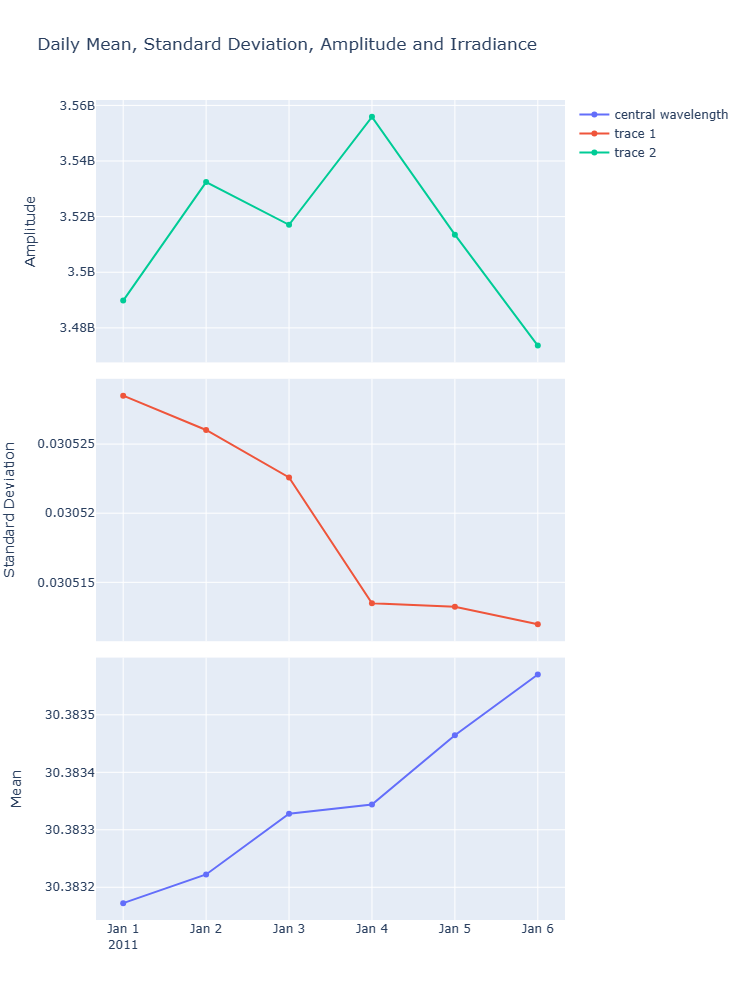

In [39]:
start_date = datetime.datetime(2011, 1, 1)
end_date = datetime.datetime(2011, 1, 6)
plot_2d_aia(start_date,end_date,a=900,b=0,c=0,d=.9,e=-0.015)

## combine

In [34]:
def select_df(start_date,end_date):
    daily_fit_df=pd.read_csv ('eve_part/data/daily_data.csv')
    daily_fit_df=daily_fit_df.set_index('time')
    daily_fit_df.index = pd.to_datetime(daily_fit_df.index)

    selected_df = daily_fit_df.loc[start_date:end_date]
    return selected_df

In [35]:
def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

def get_simu(start_date,end_date,a,b,c,d,e):
    selected_files=select_files(start_date,end_date)
    
    date_list =[] #pd.date_range(start=start_date, end=end_date,freq='D').tolist()
    mean_list=[]
    stddev_list=[]
    amplitude_list=[]


    for file in select_files(start_date,end_date):
        aia_adjusted_map=sunpy.map.Map(file)
        date,irradiance=calculate_DN(aia_adjusted_map,a,b,c,d,e)

        mean,stddev,amplitude=gaussian_fit_aia(wavelength_list_aia_absolute,irradiance)
        date_list.append(date)
        mean_list.append(mean)
        stddev_list.append(stddev)
        amplitude_list.append(amplitude)
        
        
        
    simu_data={
        'time':date_list,
        'mean':mean_list,
        'stddev':stddev_list,
        'amplitude':amplitude_list,
    }
#     print(len(date_list))
#     print(len(mean_list))
#     print(len(stddev_list))
#     print(len(amplitude_list))


#     print(date_list)
#     print(mean_list)
#     print(stddev_list)
#     print(amplitude_list)
    
    simu_df=pd.DataFrame(simu_data)
    simu_df=simu_df.set_index('time')
    return simu_df

In [36]:
def plotly_2d_combine(selected_df,simu_df,output_fig):
    # Create subplots with 3 rows and 1 column
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.01)

    # Add traces for stddev
    trace_stddev_eve=go.Scatter(x=selected_df.index, 
                             y=selected_df['median_of_stddev'],
                             name='EVE stddev',
                               line=dict(color='blue') ,)
    trace_stddev_aia=go.Scatter(x=simu_df.index, 
                             y=simu_df['stddev'],
                             name='AIA stddev',
                               line=dict(color='red') ,)
    
    fig.add_trace(trace_stddev_eve,row=1, col=1)
    fig.add_trace(trace_stddev_aia,row=1, col=1)
    fig.update_yaxes(title_text="Standard Deviation", row=1, col=1)
    
    # Add traces for amplitude
    trace_amplitude_eve=go.Scatter(x=selected_df.index, 
                             y=selected_df['median_of_amplitude']/np.nanmean(selected_df['median_of_amplitude']),
                             name='EVE amplitude',
                                  line=dict(color='blue') ,)
    trace_amplitude_aia=go.Scatter(x=simu_df.index, 
                             y=simu_df['amplitude']/np.nanmean(simu_df['amplitude']),
                             name='AIA amplitude',
                                  line=dict(color='red') ,)
    fig.add_trace(trace_amplitude_eve, row=2, col=1)
    fig.add_trace(trace_amplitude_aia, row=2, col=1)
    fig.update_yaxes(title_text="Relative amplitude", row=2, col=1)
    
    
    # Add traces for mean
    trace_mean_eve=go.Scatter(x=selected_df.index, 
                             y=selected_df['median_of_mean'],
                             name='EVE central wavelength',
                             line=dict(color='blue') ,)
    trace_mean_aia=go.Scatter(x=simu_df.index, 
                             y=simu_df['mean'],
                             name='AIA central wavelength',
                             line=dict(color='red') ,)
    fig.add_trace(trace_mean_eve,row=3, col=1,)
    fig.add_trace(trace_mean_aia,row=3, col=1,)
    fig.update_yaxes(title_text="Mean",row=3, col=1)
    fig.update_xaxes(title_text="Time", row=3, col=1)
    


    
    

    # Update the figure layout
    fig.update_layout(width=1200,height=1500,
                      title_text="Daily Median, Standard Deviation, Amplitude and Irradiance",
                     legend=dict(x=1, y=0.9)) 
    
    # Show the figure
    fig.show()
    if output_fig:
        fig.write_html(output_fig)

In [37]:
def plot_2d_combine(start_date,end_date,output_fig,a,b,c,d,e):
    selected_df=select_df(start_date,end_date)
    simu_df=get_simu(start_date,end_date,a,b,c,d,e)
    plotly_2d_combine(selected_df,simu_df,output_fig)

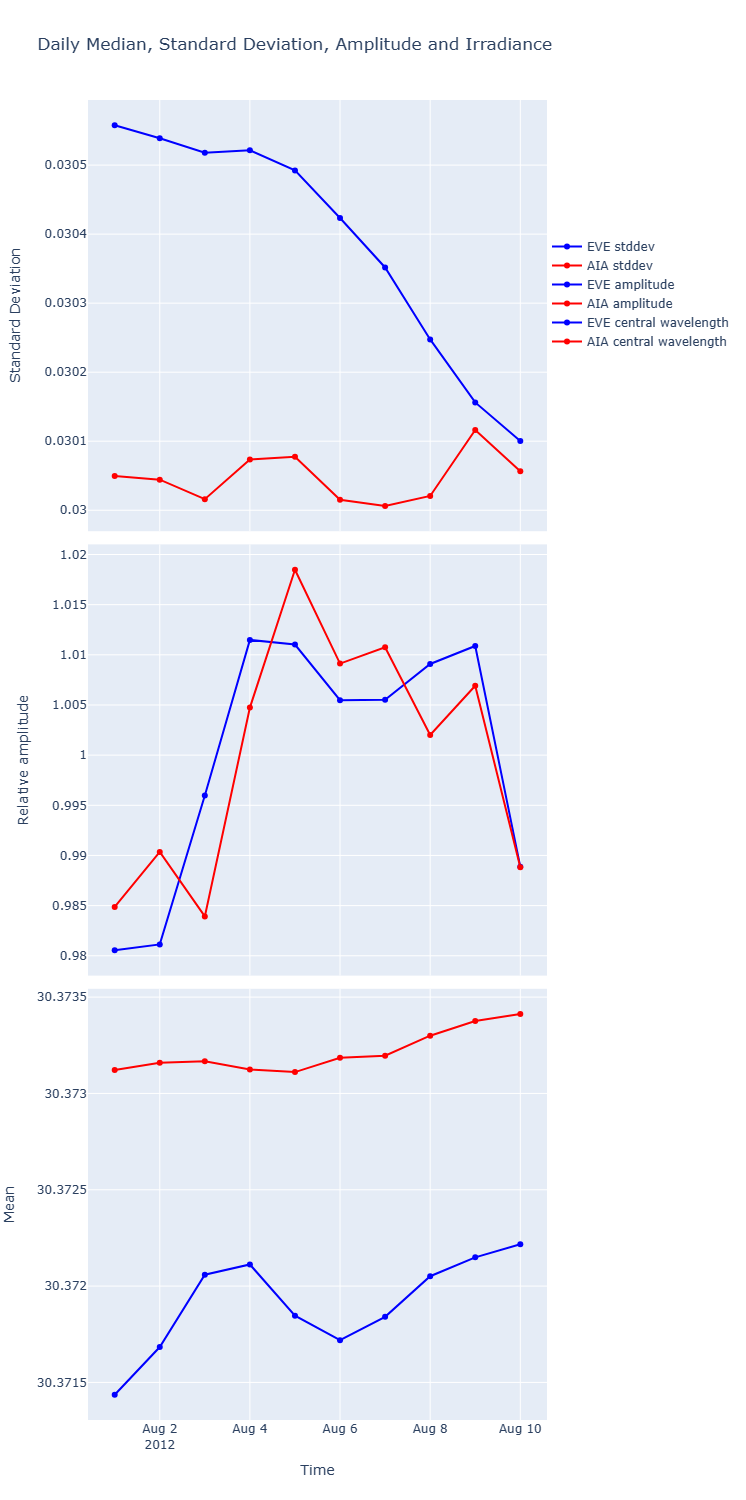

In [38]:
start_date = datetime.datetime(2012, 8, 1)
end_date = datetime.datetime(2012,8, 10)
# output_fig='P54.html'
output_fig=None
plot_2d_combine(start_date,end_date,output_fig,a=886,b=0,c=0,d=.91,e=-0.0097)

In [ ]:
a=886
b=0
c=0
d=.91
e=-0.0093
selected_df=select_df(start_date,end_date)
simu_df=get_simu(start_date,end_date,a,b,c,d,e)

In [33]:
for i in selected_df.index:
    if i not in simu_df.index:
        print(i)

NameError: name 'simu_df' is not defined

In [ ]:
simu_df.index

In [ ]:
selected_df.index

In [ ]:
importlib.reload(aia_part.gaussian_fit_aia )
from aia_part.gaussian_fit_aia import gaussian_fit_aia

### combine shadow

In [30]:
importlib.reload(aia_part.calculate_DN)
from aia_part.calculate_DN import calculate_DN

In [31]:
def select_df(start_date,end_date):
    daily_fit_df=pd.read_csv ('eve_part/data/daily_data.csv')
    daily_fit_df=daily_fit_df.set_index('time')
    daily_fit_df.index = pd.to_datetime(daily_fit_df.index)

    selected_df = daily_fit_df.loc[start_date:end_date]
    return selected_df

In [32]:
def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

def get_simu(start_date,end_date,a,b,c,d,e):
    selected_files=select_files(start_date,end_date)
    
    date_list =[] #pd.date_range(start=start_date, end=end_date,freq='D').tolist()
    mean_list=[]
    stddev_list=[]
    amplitude_list=[]


    for file in select_files(start_date,end_date):
        aia_adjusted_map=sunpy.map.Map(file)
        date,irradiance=calculate_DN(aia_adjusted_map,a,b,c,d,e)

        mean,stddev,amplitude=gaussian_fit_aia(wavelength_list_aia_absolute,irradiance)
        date_list.append(date)
        mean_list.append(mean)
        stddev_list.append(stddev)
        amplitude_list.append(amplitude)
        
        
        
    simu_data={
        'time':date_list,
        'mean':mean_list,
        'stddev':stddev_list,
        'amplitude':amplitude_list,
    }
    
    simu_df=pd.DataFrame(simu_data)
    simu_df=simu_df.set_index('time')
    return simu_df

In [33]:
def plotly_2d_combine(selected_df,simu_df,output_fig):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=.011)

    valid_day=np.where(selected_df['available_data']>=np.nanmean(selected_df['available_data'])*0.2,1,np.nan)
    x = selected_df.index
    y_median = selected_df['median_of_mean']*valid_day
    y_stddev = selected_df['stddev_of_mean']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    # EVE: Plot the mean line
    fig.add_trace(go.Scatter(x=x, y=y_median,
                                  # showlegend=False, 
                            line=dict(color='rgb(0,128,255)', ),
                            name='EVE') ,
                  row=3, col=1,)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  showlegend=False, 
                                  name='3 Std. Dev.'),
                 row=3, col=1)
    #AIA
    fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['mean'],
                              # showlegend=False, 
                        line=dict(color='rgb(255,128,53)'),
                                 name='AIA') ,
              row=3, col=1,)
    
    fig.update_yaxes(title_text="Mean (nm)",range=[30.3705, 30.3755],row=3, col=1)
    # Show the plot



    # Create a figure for stddev
    x = selected_df.index
    y_median = selected_df['median_of_stddev']*valid_day
    y_stddev = selected_df['stddev_of_stddev']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])

    fig.add_trace(go.Scatter(x=x, y=y_median,
                                showlegend=False,
                             line=dict(color='rgb(0,128,255)'),),
                          row=2, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y, mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  showlegend=False,
                                  name='3 Std. Dev.'),
                        row=2, col=1)
    #AIA
    fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['stddev'],
                              showlegend=False, 
                        line=dict(color='rgb(255,128,53)', )) ,
              row=2, col=1,)
    fig.update_yaxes(title_text="Stddev (nm)",range=[0.026, 0.032],row=2, col=1)





    # # Create a figure for amplitude
    x = selected_df.index
    y_median = selected_df['median_of_amplitude']*valid_day
    y_stddev = selected_df['stddev_of_amplitude']
    fill_x = np.concatenate([x, x[::-1]])
    fill_y = np.concatenate([y_median + 3 * y_stddev, (y_median - 3 * y_stddev)[::-1]])


    fig.add_trace(go.Scatter(x=selected_df.index, y=y_median/np.nanmean(y_median),
                                             showlegend=False,
                            line=dict(color='rgb(0,128,255)'),),
                             row=1, col=1)
    # Plot the shaded area between mean + 3 std deviations and mean - 3 std deviations
    fig.add_trace(go.Scatter(x=fill_x, y=fill_y/np.nanmean(y_median), mode='lines', 
                                  fill='tozerox', 
                                  fillcolor='rgba(0,176,246,0.2)',
                                  line=dict(color='rgba(127,255,0,0.2)'),
                                  showlegend=False, 
                                  name='3 Std. Dev.'),
                           row=1, col=1)
    #AIA
    fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['amplitude']/np.nanmean(simu_df['amplitude']),
                              showlegend=False, 
                        line=dict(color='rgb(255,128,53)', )) ,
              row=1, col=1,)
    fig.update_yaxes(title_text='relative amplitude ',
                     # range=[0.6, 1.4],
                     row=1, col=1)



    # total fig adjustment
    fig.update_layout(width=1200,height=1500,
                          title_text=f"EVE AIA",
                         legend=dict(x=1, y=0.9)) 
    fig.update_xaxes(title_text="Time",row=3, col=1)

    #save & display
    if(output_fig):
        fig.write_html(output_fig)
    fig.show() 

In [34]:
def plot_2d_combine(start_date,end_date,output_fig,a,b,c,d,e):
    selected_df=select_df(start_date,end_date)
    simu_df=get_simu(start_date,end_date,a,b,c,d,e)
    plotly_2d_combine(selected_df,simu_df,output_fig)

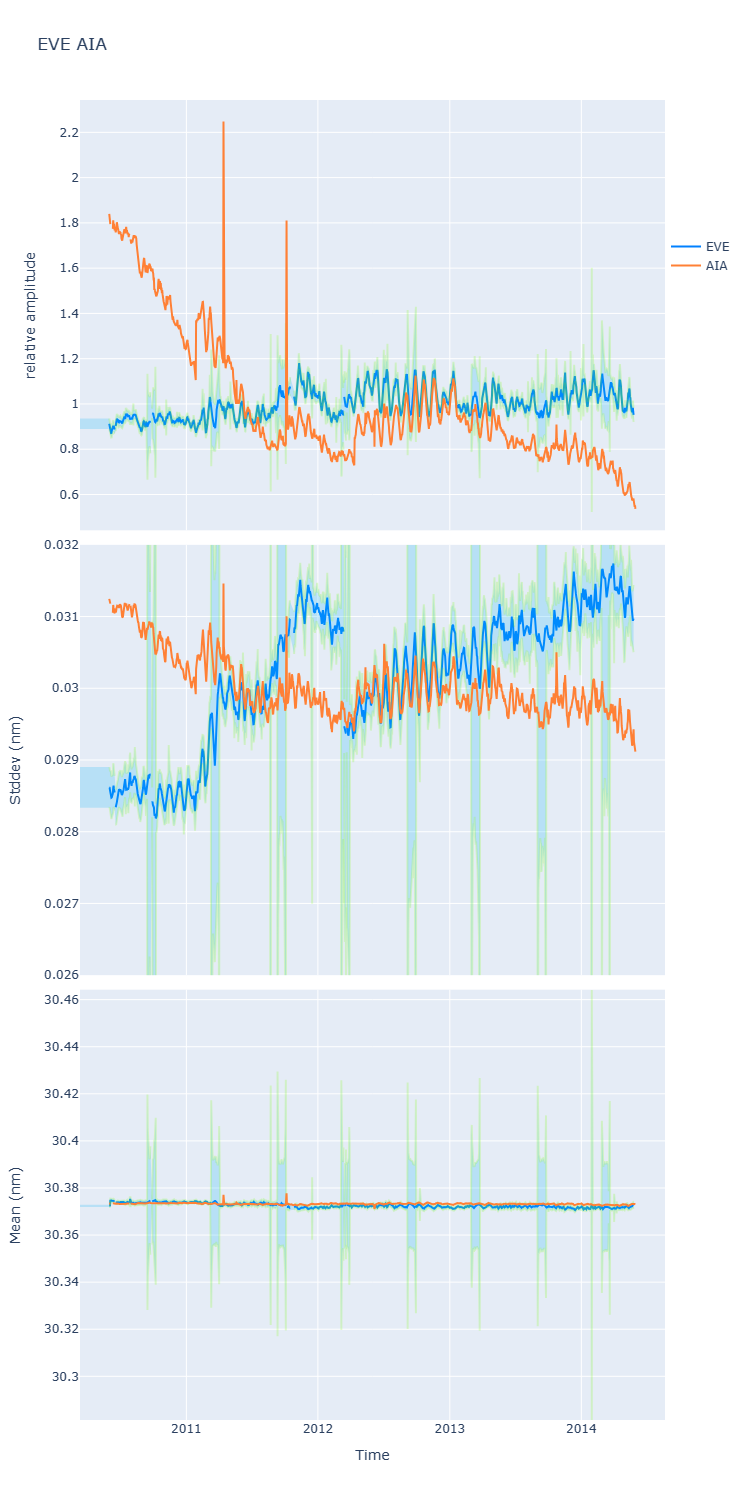

In [35]:
start_date = datetime.datetime(2010, 6, 1)
end_date = datetime.datetime(2014, 6, 1)
# end_date = datetime.datetime(2014,6, 1)
output_fig='P54.html'
# output_fig=None
plot_2d_combine(start_date,end_date,output_fig,a=886,b=-1,c=0,d=.91,e=-0.0097)

In [39]:
nested_df = pd.DataFrame({'Nested Column 1': [1, 2, 3],
                          'Nested Column 2': ['A', 'B', 'C']})

# Create the main DataFrame with a nested DataFrame column
main_df = pd.DataFrame({'Column 1': [4, 5, 6],
                        'Column 2': ['D', 'E', 'F'],
                        'Nested DataFrame': [nested_df, nested_df, nested_df]})

# Display the main DataFrame
main_df['Nested DataFrame'][0]

Nested Column 1 Nested Column 2
0                1               A
1                2               B
2                3               C